# FBProphet을 활용한 국내 코로나 바이러스 확진자 수 예측
___


## Data
    - John Hopkins University의 Covid-19 Data 사용 예정
    - 2개의 raw파일 사용
       1. RAW_global_confirmed_cases.csv
       2. RAW_global_global_deaths.csv
    - 데이터는 20년 1월 22일부터 현재까지의 누적된 수를 나타냄.
- 출처 : https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university

## 라이브러리 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from fbprophet import Prophet

## 데이터 다운로드

In [2]:
os.environ['KAGGLE_USERNAME'] = 'kimgodbang'
os.environ['KAGGLE_KEY'] = '81d66b414587b58ec1ae231dce2eeb4b'

!rm *.*
!kaggle datasets download -d antgoldbloom/covid19-data-from-john-hopkins-university
!unzip '*.zip'

df_case = pd.read_csv('RAW_global_confirmed_cases.csv')
df_death = pd.read_csv('RAW_global_deaths.csv')

rm: cannot remove '*.*': No such file or directory
  0% 0.00/4.23M [00:00<?, ?B/s]
100% 4.23M/4.23M [00:00<00:00, 39.0MB/s]
Archive:  covid19-data-from-john-hopkins-university.zip
  inflating: CONVENIENT_global_confirmed_cases.csv  
  inflating: CONVENIENT_global_deaths.csv  
  inflating: CONVENIENT_global_metadata.csv  
  inflating: CONVENIENT_us_confirmed_cases.csv  
  inflating: CONVENIENT_us_deaths.csv  
  inflating: CONVENIENT_us_metadata.csv  
  inflating: RAW_global_confirmed_cases.csv  
  inflating: RAW_global_deaths.csv   
  inflating: RAW_us_confirmed_cases.csv  
  inflating: RAW_us_deaths.csv       


In [3]:
# 받은 데이터 확인 -(1)
print(df_case.shape, df_death.shape)

(274, 437) (274, 437)


In [4]:
# 받은 데이터 확인 -(2)
df_case.head()

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21
0,Afghanistan,NaN,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,55557,55575,55580,55604,55617,55646,55664,55680,55696,55707,55714,55733,55759,55770,55775,55827,55840,55847,55876,55876,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153,56177,56192,56226,56254,56290,56294,56322
1,Albania,NaN,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,96838,97909,99062,100246,101285,102306,103327,104313,105229,106215,107167,107931,108823,109674,110521,111301,112078,112897,113580,114209,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544,121847,122295,122767,123216,123641,124134,124419
2,Algeria,NaN,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,111418,111600,111764,111917,112094,112279,112461,112622,112805,112960,113092,113255,113430,113593,113761,113948,114104,114234,114382,114543,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255,116349,116438,116543,116657,116750,116836,116946
3,Andorra,NaN,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10610,10645,10672,10699,10712,10739,10775,10799,10822,10849,10866,10889,10908,10948,10976,10998,11019,11042,11069,11089,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545,11591,11638,11687,11732,11809,11850,11888
4,Angola,NaN,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20452,20478,20499,20519,20548,20584,20640,20695,20759,20782,20807,20854,20882,20923,20981,21026,21055,21086,21108,21114,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757,21774,21836,21914,21961,22031,22063,22132


In [5]:
df_death.head()

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21
0,Afghanistan,NaN,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2430,2430,2430,2432,2433,2435,2436,2438,2442,2443,2443,2444,2446,2446,2446,2449,2449,2449,2451,2451,2451,2451,2454,2454,2457,2459,2460,2460,2462,2462,2462,2463,2464,2466,2466,2467,2467,2469,2470,2472
1,Albania,NaN,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1617,1636,1653,1666,1681,1696,1715,1736,1756,1775,1796,1816,1835,1856,1876,1897,1918,1939,1956,1969,1986,2002,2018,2030,2045,2060,2077,2092,2106,2122,2133,2137,2145,2156,2171,2184,2192,2204,2210,2216
2,Algeria,NaN,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2950,2954,2958,2961,2964,2967,2970,2973,2977,2979,2983,2987,2991,2996,3002,3007,3010,3013,3018,3022,3026,3028,3031,3034,3036,3040,3045,3048,3051,3053,3055,3057,3061,3066,3069,3071,3074,3077,3080,3084
3,Andorra,NaN,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107,107,107,107,109,110,110,110,110,110,110,110,110,112,112,112,112,112,112,112,112,112,112,112,113,113,113,113,113,113,113,113,113,113,114,114,114,115,115,115
4,Angola,NaN,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,498,498,498,499,499,500,501,502,504,506,508,508,510,510,511,511,512,514,515,516,516,517,519,520,521,521,522,522,522,524,526,527,530,530,532,532,532,533,533,534


## Data EDA

In [6]:
df_case['Country/Region'].value_counts()

China             33
Canada            16
France            12
United Kingdom    12
Australia          8
                  ..
Singapore          1
Sierra Leone       1
Zimbabwe           1
Russia             1
Libya              1
Name: Country/Region, Length: 192, dtype: int64

In [7]:
df_death['Country/Region'].value_counts()

China             33
Canada            16
France            12
United Kingdom    12
Australia          8
                  ..
Singapore          1
Sierra Leone       1
Zimbabwe           1
Russia             1
Libya              1
Name: Country/Region, Length: 192, dtype: int64

In [8]:
df_case.columns

Index(['Country/Region', 'Province/State', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '3/20/21', '3/21/21', '3/22/21', '3/23/21', '3/24/21', '3/25/21',
       '3/26/21', '3/27/21', '3/28/21', '3/29/21'],
      dtype='object', length=437)

In [9]:
df_death.columns

Index(['Country/Region', 'Province/State', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '3/20/21', '3/21/21', '3/22/21', '3/23/21', '3/24/21', '3/25/21',
       '3/26/21', '3/27/21', '3/28/21', '3/29/21'],
      dtype='object', length=437)

## 시계열 데이터를 다루기 위해서 데이터 구조 변경

In [10]:
df = df_case.drop(['Lat','Long'], axis=1)
df_case = df.groupby('Country/Region'	).sum().transpose()
df_case.index.name = 'Date'
df_case.reset_index(inplace=True)
df_case['Date'] = df_case['Date'].apply(lambda x : pd.to_datetime(str(x)))
df_case.set_index('Date', inplace = True)

In [11]:
df_case.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0


In [12]:
df = df_death.drop(['Lat','Long'], axis=1)
df_death = df.groupby('Country/Region'	).sum().transpose()
df_death.index.name = 'Date'
df_death.reset_index(inplace=True)
df_death['Date'] = df_death['Date'].apply(lambda x : pd.to_datetime(str(x)))
df_death.set_index('Date', inplace = True)

In [13]:
df_death.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Visualization

In [14]:
# 누적확진자 수 및 누적사망자 수 파악


In [15]:
df_case.index[-1]

Timestamp('2021-03-29 00:00:00')

In [16]:
# 누적확진자 수 상위 10개국 
case10 = df_case.loc[df_case.index[-1]].sort_values(ascending=False)[:10]
case10

Country/Region
US                30331025
Brazil            12573615
India             12039644
France             4615295
Russia             4477916
United Kingdom     4351796
Italy              3544957
Spain              3270825
Turkey             3240577
Germany            2794949
Name: 2021-03-29 00:00:00, dtype: int64

In [17]:
# 누적 사망자 수 상위 10개국
death10 = df_death.loc[df_death.index[-1]][case10.index]
death10

Country/Region
US                550003
Brazil            313866
India             162114
France             95114
Russia             96413
United Kingdom    126857
Italy             108350
Spain              75199
Turkey             31230
Germany            76139
Name: 2021-03-29 00:00:00, dtype: int64

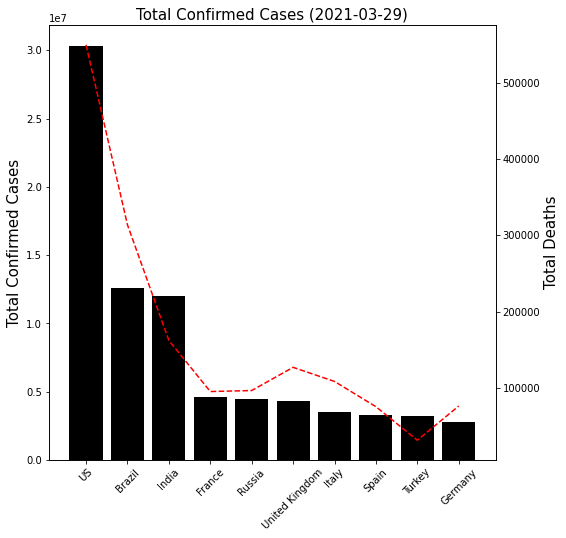

In [18]:
# 시각화

plt.figure(figsize=(8,8))
sns.barplot(x =case10.index, y=case10, color='black')
plt.xticks(rotation=45, size=10)
plt.ylabel('Total Confirmed Cases', size=15)
plt.xlabel('', size=15)
plt.title('Total Confirmed Cases (%s)' % case10.name.strftime('%Y-%m-%d'), size=15)


ax = plt.gca()
ax2 = ax.twinx() 
ax2.plot(death10.index, death10, 'r--')
ax2.set_ylabel('Total Deaths', size=15)
plt.show()


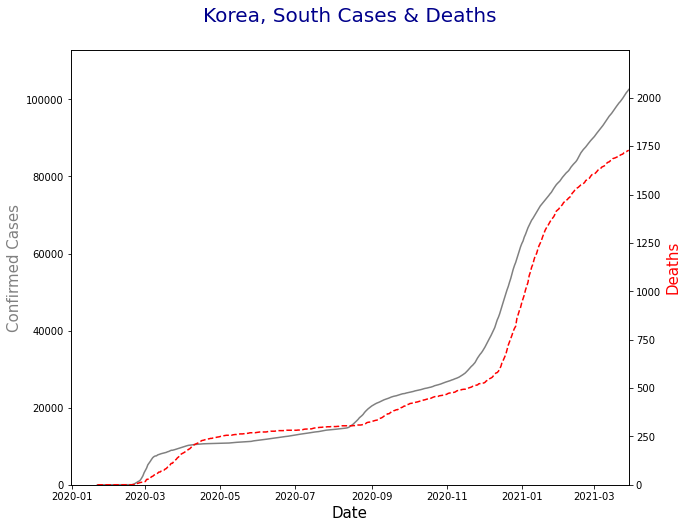

In [37]:
# 한국의 확진자 수 및 사망자 수 추이
korea = 'Korea, South'

plt.figure(figsize=(10,8))
plt.plot(df_case[country].index, df_case[country],color = 'gray')

plt.title(korea + ' Cases & Deaths' +'\n', size=20 , color='Darkblue')
plt.ylabel('Confirmed Cases', color='gray',size=15)

plt.xlim(right = df_case.index[-1])
plt.ylim(0, df_case[korea].max()*1.1)
plt.xlabel('Date',size=15)

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df_death.index, df_death[korea], 'r--')

ax2.set_ylabel('Deaths', color='red', size=15)
ax2.set_ylim(0, df_death[country].max()*1.3)

plt.show()

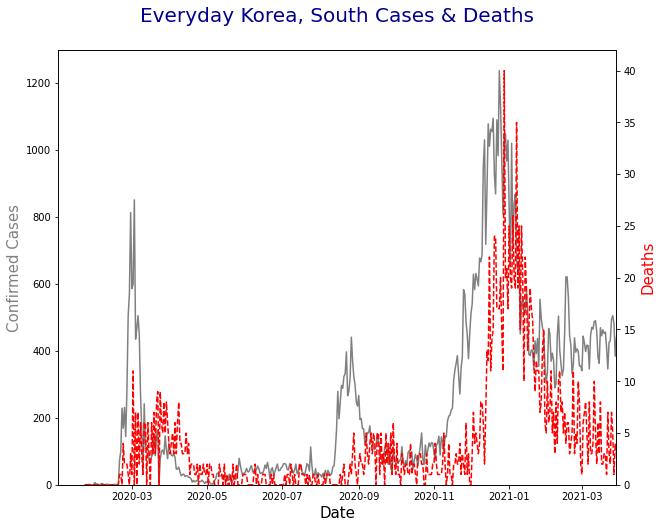

In [40]:
# 한국의 일일 확진자 수 및 사망자 수 추이

plt.figure(figsize=(10,8))
plt.plot(df_case.index, df_case[korea].diff(), color='gray')

plt.title('Everyday '+ korea + ' Cases & Deaths' +'\n', size=20 , color='Darkblue')
plt.ylabel('Confirmed Cases', color='gray',size=15)



plt.xlim(right = df_case.index[-1])
plt.ylim(0)
plt.xlabel('Date',size=15)

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df_death.index, df_death[korea].diff(), 'r--')

ax2.set_ylabel('Deaths', color='red', size=15)
ax2.set_ylim(0)

plt.show()

## Preprocessing For Modeling
  - Training the Korea's Confirms data

In [41]:
df_case.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0


In [49]:
df_case.reset_index().head()

Country/Region,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
4,2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0


In [51]:
df_case.reset_index()[['Date', korea]]

Country/Region,Date,"Korea, South"
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3
...,...,...
428,2021-03-25,100770
429,2021-03-26,101275
430,2021-03-27,101757
431,2021-03-28,102141


In [52]:
df = df_case.reset_index()[['Date', korea]]

In [78]:
df.to_numpy().shape

(433, 2)

In [105]:
df = pd.DataFrame(df.to_numpy(), columns=['ds', 'y'])
df.head()

,ds,y
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3


In [106]:
# Split the Train & Test dataset
# I will split the dataset into Two dataset which ratio is 9:1
from math import floor
ratio = floor(df.shape[0]) * (1-0.1)
train_df = df.loc[:ratio]
test_df = df.loc[ratio:]

In [107]:
print(train_df.shape)
print(test_df.shape)

(390, 2)
(43, 2)


In [108]:
train_df.head()

,ds,y
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3


In [109]:
print(train_df.tail(),'\n',test_df.head())

            ds      y
385 2021-02-10  82434
386 2021-02-11  82837
387 2021-02-12  83199
388 2021-02-13  83525
389 2021-02-14  83869 
             ds      y
390 2021-02-15  84325
391 2021-02-16  84946
392 2021-02-17  85567
393 2021-02-18  86128
394 2021-02-19  86574


## Training from Prophet Model

In [110]:
model = Prophet(changepoint_range=1.0)
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


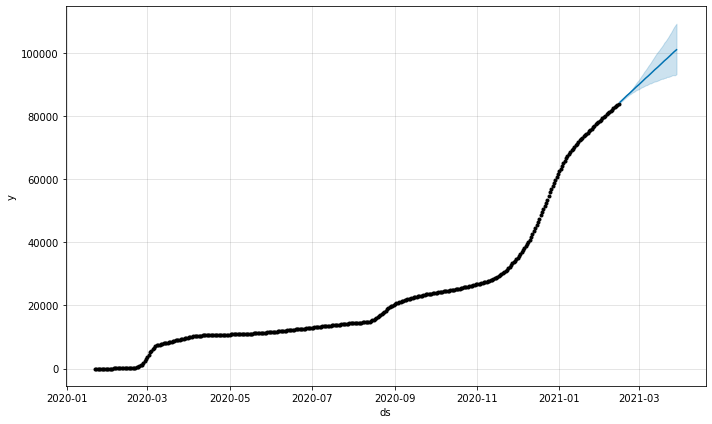

In [112]:
# Prdict result
pred = model.predict(test_df)
model.plot(pred);

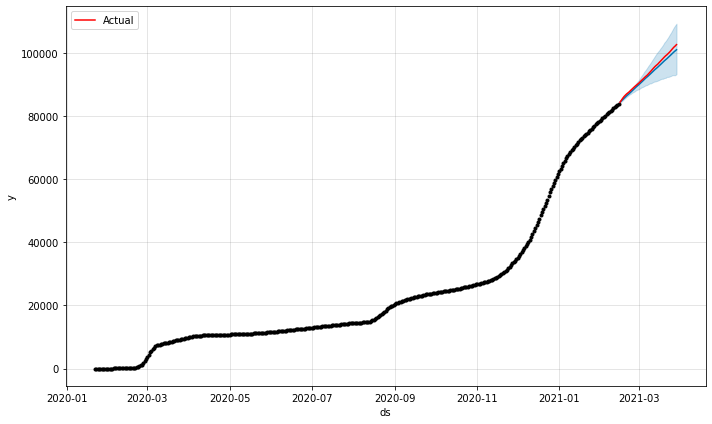

In [123]:
# Compare with Actual value

fig = model.plot(pred)
plt.plot(test_df['ds'], test_df['y'] , 'r-', label='Actual')
plt.legend(loc='upper left')
plt.show()

In [129]:
# Evaluate

r2 = r2_score(test_df['y'], pred['yhat'])
print( 'R2 SCORE : ', r2)

R2 SCORE :  0.9705418630630126


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


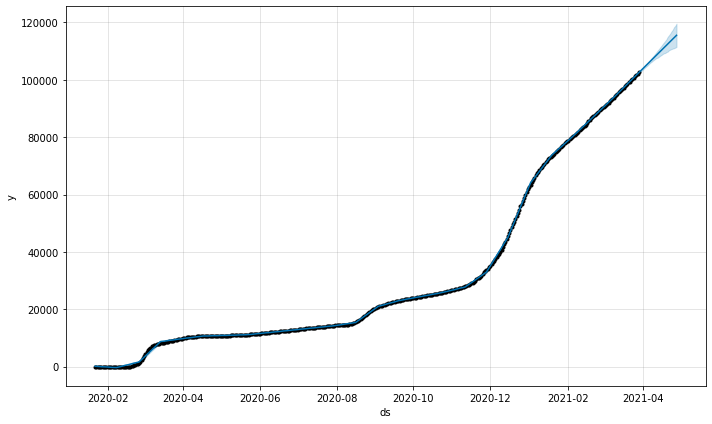

In [149]:
# Predicting after 1 months

model = Prophet(changepoint_range=1.0)
model.fit(df)
months = model.make_future_dataframe(30)
predict = model.predict(months)
model.plot(predict);

In [145]:
months[432:].head()

,ds
432,2021-03-29
433,2021-03-30
434,2021-03-31
435,2021-04-01
436,2021-04-02


In [147]:
predict.yhat[432:].head().diff()

432           NaN
433    449.947937
434    445.454878
435    444.067461
436    443.139704
Name: yhat, dtype: float64